# Multilayer Perceptron
**Comparing Federated Machine Learning to Centralized Machine Learning**

## Imports & Configs

In [32]:
import pandas as pd
import numpy as np
import multiprocessing
import torch
from torch.utils.data import DataLoader
from datasets.utils.logging import disable_progress_bar
from torchviz import make_dot
from torchinfo import summary
from IPython.display import Image, display

from utils import CustomDataset, set_parameters, get_parameters, weighted_average
from data_loaders import load_federated_datasets, load_federated_datasets_by_gender, load_federated_datasets_by_age, load_federated_datasets_by_education
from model import BinaryMLP, train, evaluate
from FlowerClient import FlowerClient

import flwr as fl
from flwr.client import Client, ClientApp
from flwr.common import Context
from flwr.server.strategy import FedAvg
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation

In [33]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    n_gpu = float(torch.cuda.device_count())
    device_name = torch.cuda.get_device_name(DEVICE)
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    device_name = "Apple Silicon"
    n_gpu = 0.0
else:
    DEVICE = torch.device("cpu")
    device_name = "CPU"
    n_gpu = 0.0
    
disable_progress_bar()
torch.manual_seed(0)

n_cores = multiprocessing.cpu_count()
print(f"Number of GPUs: {n_gpu} / Number of CPU Cores: {n_cores}")
print(f"Training on {device_name}")
print(f"Flower {fl.__version__} / PyTorch {torch.__version__}")

Number of GPUs: 1.0 / Number of CPU Cores: 24
Training on NVIDIA GeForce RTX 4090
Flower 1.14.0 / PyTorch 2.5.1+cu124


In [34]:
NUM_CLIENTS = 5
BATCH_SIZE = 32
NUM_EPOCHS = 8
NUM_ROUNDS = 5

## Loading Data

In [35]:
train_df = pd.read_csv('./Data/adult_train.csv')
test_df = pd.read_csv('./Data/adult_train.csv')
concated_df = pd.concat([train_df, test_df], ignore_index=True)

label_column_name = 'income'
x_train = train_df.drop(columns=[label_column_name]).values
x_test = test_df.drop(columns=[label_column_name]).values
y_train = train_df[label_column_name].values
y_test = test_df[label_column_name].values

## Centralized Training

In [36]:
train_centralized = CustomDataset(x_train, y_train)
test_centralized = CustomDataset(x_test, y_test)
train_centralized_loader = DataLoader(train_centralized, batch_size=32, shuffle=True)
test_centralized_loader = DataLoader(test_centralized, batch_size=32, shuffle=True)

In [37]:
model = BinaryMLP().to(DEVICE)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_centralized_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)

c_loss, c_accuracy, c_precision, c_recall, c_f1 = evaluate(model, test_centralized_loader, DEVICE)
print(f"Centralized Model - Average Loss: {c_loss:.4f}, Accuracy: {c_accuracy:.4f}, Precision: {c_precision:.4f}, Recall: {c_recall:.4f}, F1: {c_f1:.4f}")

Centralized Model - Average Loss: 0.3060, Accuracy: 0.8608, Precision: 0.7657, Recall: 0.6080, F1: 0.6778


In [38]:
model = BinaryMLP().to(DEVICE)

# Switch model to evaluation mode
model.eval()

# Create a dummy input tensor with the correct input shape
dummy_input = torch.randn(1, 97).to(DEVICE)  # 97 is the input dimension size

# Generate the computation graph
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

file_path = "/tmp/model_architecture.png"
dot.render(file_path, format="png")

# Display the image in the notebook
display(Image(filename=file_path))

In [39]:
model_summary = summary(model=model, input_size=(BATCH_SIZE, 97), col_names=("input_size", "output_size"))
model_summary

Layer (type:depth-idx)                   Input Shape               Output Shape
BinaryMLP                                [32, 97]                  [32, 1]
├─Sequential: 1-1                        [32, 97]                  [32, 1]
│    └─Linear: 2-1                       [32, 97]                  [32, 64]
│    └─ReLU: 2-2                         [32, 64]                  [32, 64]
│    └─Dropout: 2-3                      [32, 64]                  [32, 64]
│    └─BatchNorm1d: 2-4                  [32, 64]                  [32, 64]
│    └─Linear: 2-5                       [32, 64]                  [32, 32]
│    └─ReLU: 2-6                         [32, 32]                  [32, 32]
│    └─Dropout: 2-7                      [32, 32]                  [32, 32]
│    └─BatchNorm1d: 2-8                  [32, 32]                  [32, 32]
│    └─Linear: 2-9                       [32, 32]                  [32, 16]
│    └─ReLU: 2-10                        [32, 16]                  [32, 16]
│    └─Dro

## Federated Training

In [40]:
backend_config = {
    "client_resources": {
        "num_cpus": n_cores,
        "num_gpus": n_gpu
    }
}

In [41]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=1.0, 
        fraction_evaluate=0.5,
        min_available_clients=NUM_CLIENTS, 
        fit_metrics_aggregation_fn=weighted_average
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

### Federated with 5 Clients

In [42]:
def client_fn(context: Context) -> Client:
    model = BinaryMLP().to(DEVICE)
    partition_id = context.node_config["partition-id"]

    trainloaders, testloaders = load_federated_datasets(
        x_train,
        x_test,
        y_train,
        y_test,
        NUM_CLIENTS,
        BATCH_SIZE
    )

    trainloader = trainloaders[partition_id]
    testloader = testloaders[partition_id]

    return FlowerClient(model, trainloader, testloader, NUM_EPOCHS, DEVICE).to_client()

In [43]:
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configur

In [44]:
trainloaders_5, testloaders_5 = load_federated_datasets(
    x_train,
    x_test,
    y_train,
    y_test,
    NUM_CLIENTS,
    BATCH_SIZE
)

In [45]:
accuracy_5 = []
f1_5 = []
for trainloader, testloader in zip(trainloaders_5, testloaders_5):
    train(model, trainloader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    loss, accuracy, precision, recall, f1 = evaluate(model, testloader, DEVICE)
    accuracy_5.append(accuracy)
    f1_5.append(f1)


print(f"Local mean accuracy: {np.mean(accuracy_5):4f}")
print(f"Local mean f1 score: {np.mean(f1_5):4f}")

Local mean accuracy: 0.540094
Local mean f1 score: 0.322292


### Federated with 50 Clients

In [46]:
NUM_CLIENTS = 50

client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 50 clients (out of 50)
INFO :      aggregate_fit: received 50 results and 0 failures
INFO :      configure_evaluate: strategy sampled 25 clients (out of 50)
INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 50 clients (out of 50)
INFO :      aggregate_fit: received 50 results and 0 failures
INFO :      configure_evaluate: strategy sampled 25 clients (out of 50)
INFO :      aggregate_evaluate: received 25 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :  

In [47]:
trainloaders_50, testloaders_50 = load_federated_datasets(
    x_train,
    x_test,
    y_train,
    y_test,
    NUM_CLIENTS,
    BATCH_SIZE
)

In [48]:
accuracy_50 = []
f1_50 = []
for trainloader, testloader in zip(trainloaders_50, testloaders_50):
    train(model, trainloader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    loss, accuracy, precision, recall, f1 = evaluate(model, testloader, DEVICE)
    accuracy_50.append(accuracy)
    f1_50.append(f1)

print(f"Local mean accuracy: {np.mean(accuracy_50):4f}")
print(f"Local mean f1 score: {np.mean(f1_50):4f}")

Local mean accuracy: 0.539578
Local mean f1 score: 0.314493


### Federated with 200 Clients

In [52]:
NUM_CLIENTS = 200

client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)
INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 200)
INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 200 clients (out of 200)
INFO :      aggregate_fit: received 200 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 200)
INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND

In [53]:
trainloaders_200, testloaders_200 = load_federated_datasets(
    x_train,
    x_test,
    y_train,
    y_test,
    NUM_CLIENTS,
    BATCH_SIZE
)

In [54]:
accuracy_200 = []
f1_200 = []
for trainloader, testloader in zip(trainloaders_200, testloaders_200):
    train(model, trainloader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    loss, accuracy, precision, recall, f1 = evaluate(model, testloader, DEVICE)
    accuracy_200.append(accuracy)
    f1_200.append(f1)

print(f"Local mean accuracy: {np.mean(accuracy_200):4f}")
print(f"Local mean f1 score: {np.mean(f1_200):4f}")

Local mean accuracy: 0.504576
Local mean f1 score: 0.325485


### Dist

#### Gender

In [55]:
def client_fn_gender(context: Context) -> Client:
    model = BinaryMLP().to(DEVICE)
    partition_id = context.node_config["partition-id"]

    trainloaders, testloaders = load_federated_datasets_by_gender(
        x_train,
        x_test,
        y_train,
        y_test,
        train_df,
        test_df,
        NUM_CLIENTS,
        BATCH_SIZE,
        'sex_Male'
    )

    trainloader = trainloaders[partition_id]
    testloader = testloaders[partition_id]

    return FlowerClient(model, trainloader, testloader, NUM_EPOCHS, DEVICE).to_client()

In [56]:
NUM_CLIENTS = 10

client = ClientApp(client_fn=client_fn_gender)
server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      

In [57]:
trainloaders_gender, testloaders_gender = load_federated_datasets_by_gender(
        x_train,
        x_test,
        y_train,
        y_test,
        train_df,
        test_df,
        NUM_CLIENTS,
        BATCH_SIZE,
        'sex_Male'
    )

In [58]:
accuracy_gender = []
f1_gender = []
for trainloader, testloader in zip(trainloaders_gender, testloaders_gender):
    train(model, trainloader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    loss, accuracy, precision, recall, f1 = evaluate(model, testloader, DEVICE)
    accuracy_gender.append(accuracy)
    f1_gender.append(f1)

print(f"Local mean accuracy: {np.mean(accuracy_gender):4f}")
print(f"Local mean f1 score: {np.mean(f1_gender):4f}")

Local mean accuracy: 0.547380
Local mean f1 score: 0.259625


#### Education Level

In [59]:
def client_fn_education(context: Context) -> Client:
    model = BinaryMLP().to(DEVICE)
    partition_id = context.node_config["partition-id"]

    trainloaders, testloaders = load_federated_datasets_by_education(
        x_train,
        x_test,
        y_train,
        y_test,
        train_df,
        test_df,
        NUM_CLIENTS,
        BATCH_SIZE
    )

    trainloader = trainloaders[partition_id]
    testloader = testloaders[partition_id]

    return FlowerClient(model, trainloader, testloader, NUM_EPOCHS, DEVICE).to_client()

In [60]:
NUM_CLIENTS = 10

client = ClientApp(client_fn=client_fn_education)
server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      

In [61]:
 trainloaders_edu, testloaders_edu = load_federated_datasets_by_education(
        x_train,
        x_test,
        y_train,
        y_test,
        train_df,
        test_df,
        NUM_CLIENTS,
        BATCH_SIZE
    )

In [62]:
accuracy_edu = []
f1_edu = []
for trainloader, testloader in zip(trainloaders_edu, testloaders_edu):
    train(model, trainloader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    loss, accuracy, precision, recall, f1 = evaluate(model, testloader, DEVICE)
    accuracy_edu.append(accuracy)
    f1_edu.append(f1)

print(f"Local mean accuracy: {np.mean(accuracy_edu):4f}")
print(f"Local mean f1 score: {np.mean(f1_edu):4f}")

Local mean accuracy: 0.544481
Local mean f1 score: 0.354440


#### Age

In [63]:
def client_fn_age(context: Context) -> Client:
    model_age = BinaryMLP().to(DEVICE)
    partition_id = context.node_config["partition-id"]

    mean_age = 38.58
    std_age = 13.64
    scaled_min = (31 - mean_age) / std_age
    scaled_max = (50 - mean_age) / std_age

    trainloaders, testloaders = load_federated_datasets_by_age(
        x_train,
        x_test,
        y_train,
        y_test,
        train_df,
        test_df,
        NUM_CLIENTS,
        BATCH_SIZE,
        'age',
        scaled_min,
        scaled_max
    )

    trainloader_age = trainloaders[partition_id]
    testloader_age = testloaders[partition_id]
    return FlowerClient(model_age, trainloader_age, testloader_age, NUM_EPOCHS, DEVICE).to_client()

In [64]:
NUM_CLIENTS = 10

client = ClientApp(client_fn=client_fn_age)
server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      

In [67]:
mean_age = 38.58
std_age = 13.64
scaled_min = (31 - mean_age) / std_age
scaled_max = (50 - mean_age) / std_age

trainloaders_age, testloaders_age = load_federated_datasets_by_age(
        x_train,
        x_test,
        y_train,
        y_test,
        train_df,
        test_df,
        NUM_CLIENTS,
        BATCH_SIZE,
        'age',
        scaled_min,
        scaled_max
    )

In [68]:
accuracy_age = []
f1_age = []
for trainloader, testloader in zip(trainloaders_age, testloaders_age):
    train(model, trainloader, criterion, optimizer, NUM_EPOCHS, DEVICE)
    loss, accuracy, precision, recall, f1 = evaluate(model, testloader, DEVICE)
    accuracy_age.append(accuracy)
    f1_age.append(f1)

print(f"Local mean accuracy: {np.mean(accuracy_age):4f}")
print(f"Local mean f1 score: {np.mean(f1_age):4f}")

Local mean accuracy: 0.546077
Local mean f1 score: 0.311706


## Comparison

In [74]:
import json

with open("results.json", "r") as file:
    data = json.load(file)

averages = {}

local_mean_acc = {
    "5_clients": np.mean(accuracy_5),
    "50_clients": np.mean(accuracy_50),
    "200_clients": np.mean(accuracy_200),
    "gender": np.mean(accuracy_gender),
    "education": np.mean(accuracy_edu),
    "age": np.mean(accuracy_age),
}

local_mean_f1s = {
    "5_clients": np.mean(f1_5),
    "50_clients": np.mean(f1_50),
    "200_clients": np.mean(f1_200),
    "gender": np.mean(f1_gender),
    "education": np.mean(f1_edu),
    "age": np.mean(f1_age),
}

for category, metrics in data.items():
    averages[category] = {}  
    for metric, scores in metrics.items():
        average_score = sum(scores) / len(scores)
        averages[category][metric] = average_score

    if category in local_mean_acc:
        averages[category]["local_mean_accuracy"] = local_mean_acc[category]
    if category in local_mean_f1s:
        averages[category]["local_mean_f1"] = local_mean_f1s[category]

for category, metrics in averages.items():
    print(f"{category}:")
    for metric, value in metrics.items():
        if isinstance(value, (int, float)): 
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: {value}")

centralized:
  accuracy: 0.8608
  f1_score: 0.6778
  precision: 0.7657
  recall: 0.6080
5_clients:
  accuracy: 0.8568
  f1_score: 0.6448
  precision: 0.7906
  recall: 0.5519
  local_mean_accuracy: 0.5401
  local_mean_f1: 0.3223
50_clients:
  accuracy: 0.8506
  f1_score: 0.6431
  precision: 0.7571
  recall: 0.5623
  local_mean_accuracy: 0.5396
  local_mean_f1: 0.3145
200_clients:
  accuracy: 0.8272
  f1_score: 0.6487
  precision: 0.6333
  recall: 0.6750
  local_mean_accuracy: 0.5046
  local_mean_f1: 0.3255
gender:
  accuracy: 0.8638
  f1_score: 0.6553
  precision: 0.7418
  recall: 0.5892
  local_mean_accuracy: 0.5474
  local_mean_f1: 0.2596
education:
  accuracy: 0.8363
  f1_score: 0.4932
  precision: 0.7827
  recall: 0.3732
  local_mean_accuracy: 0.5445
  local_mean_f1: 0.3544
age:
  accuracy: 0.8560
  f1_score: 0.6416
  precision: 0.7734
  recall: 0.5491
  local_mean_accuracy: 0.5461
  local_mean_f1: 0.3117


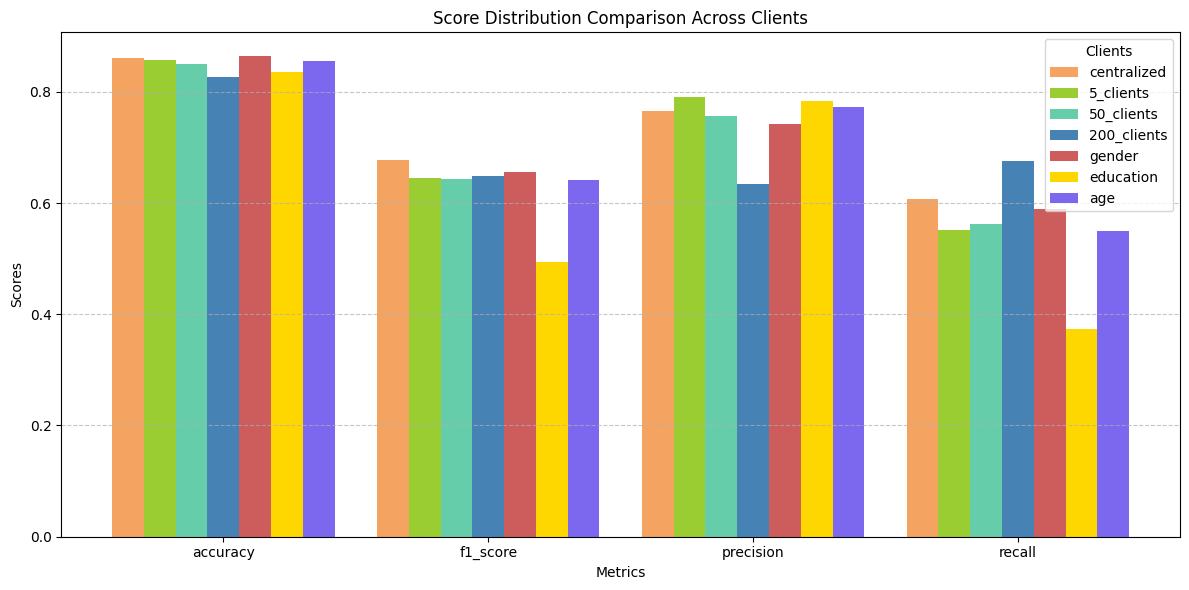

In [16]:
import matplotlib.pyplot as plt
categories = list(averages.keys())
metrics = list(averages[categories[0]].keys())

x = np.arange(len(metrics)) 
width = 0.12 

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['sandybrown', 'yellowgreen', 'mediumaquamarine', 'steelblue', 'indianred', 'gold', 'mediumslateblue']

for i, category in enumerate(categories):
    scores = [np.mean(averages[category][metric]) for metric in metrics]
    ax.bar(x + i * width, scores, width, label=category, color=colors[i % len(colors)])

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Score Distribution Comparison Across Clients")
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(title="Clients")

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

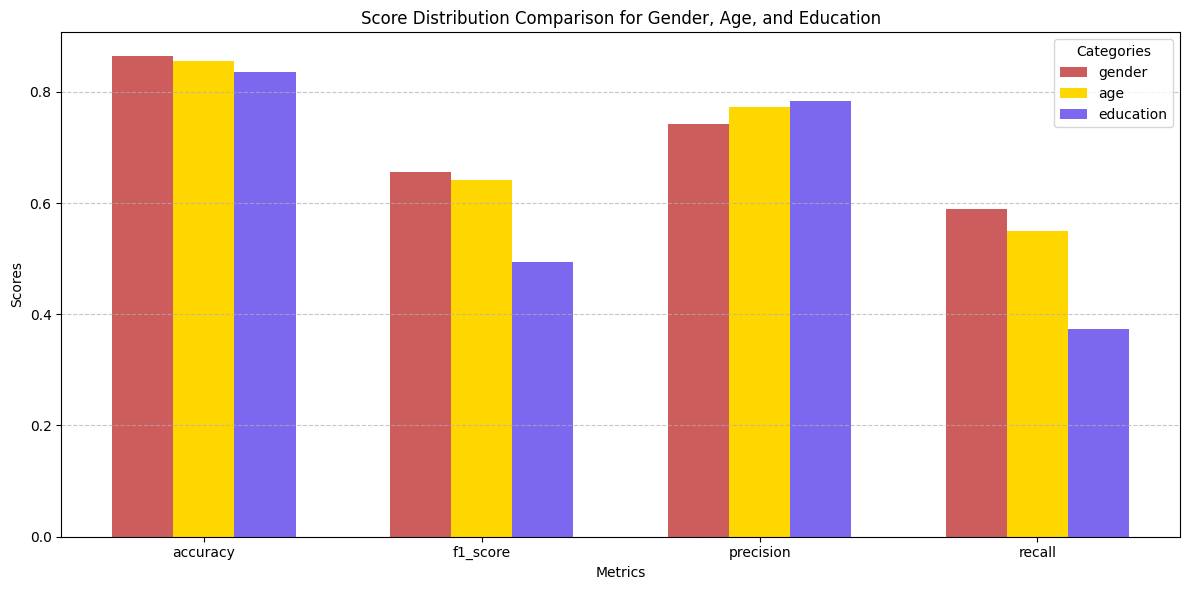

In [17]:
categories = ['gender', 'age', 'education']
metrics = list(averages[categories[0]].keys())

x = np.arange(len(metrics)) 
width = 0.22 

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['indianred', 'gold', 'mediumslateblue']

for i, category in enumerate(categories):
    scores = [np.mean(averages[category][metric]) for metric in metrics]
    ax.bar(x + i * width, scores, width, label=category, color=colors[i % len(colors)])

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Score Distribution Comparison for Gender, Age, and Education")
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(title="Categories")

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

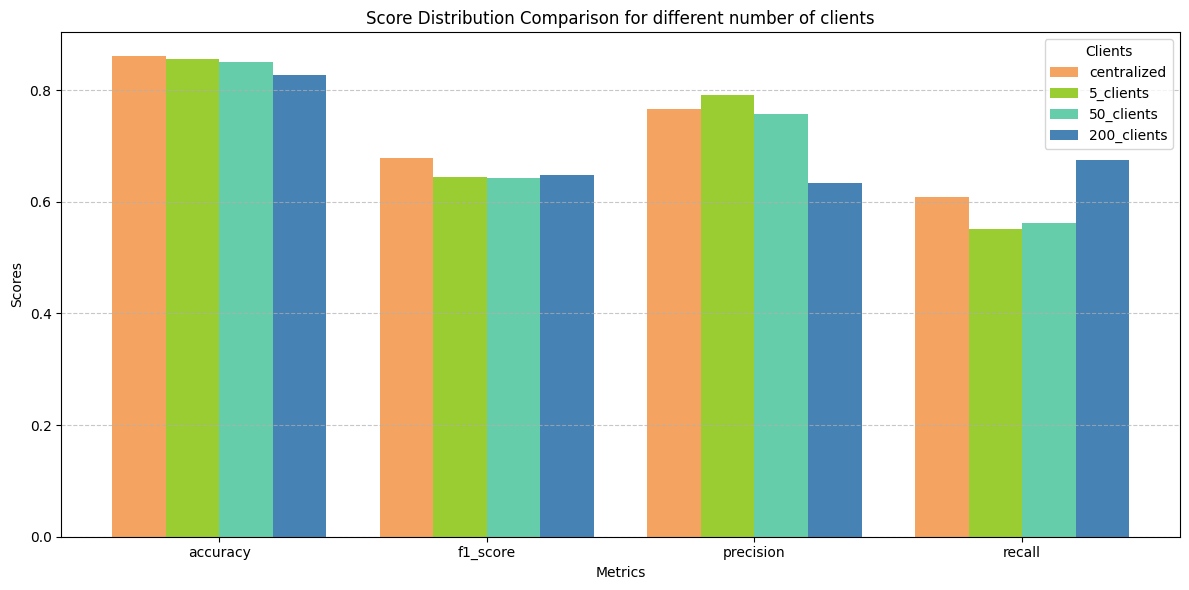

In [27]:
categories = ['centralized', '5_clients', '50_clients', '200_clients']
metrics = list(averages[categories[0]].keys())

x = np.arange(len(metrics)) 
width = 0.2 

fig, ax = plt.subplots(figsize=(12, 6))

colors =['sandybrown', 'yellowgreen', 'mediumaquamarine', 'steelblue']

for i, category in enumerate(categories):
    scores = [np.mean(averages[category][metric]) for metric in metrics]
    ax.bar(x + i * width, scores, width, label=category, color=colors[i % len(colors)])

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Score Distribution Comparison for different number of clients")
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend(title="Clients")

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

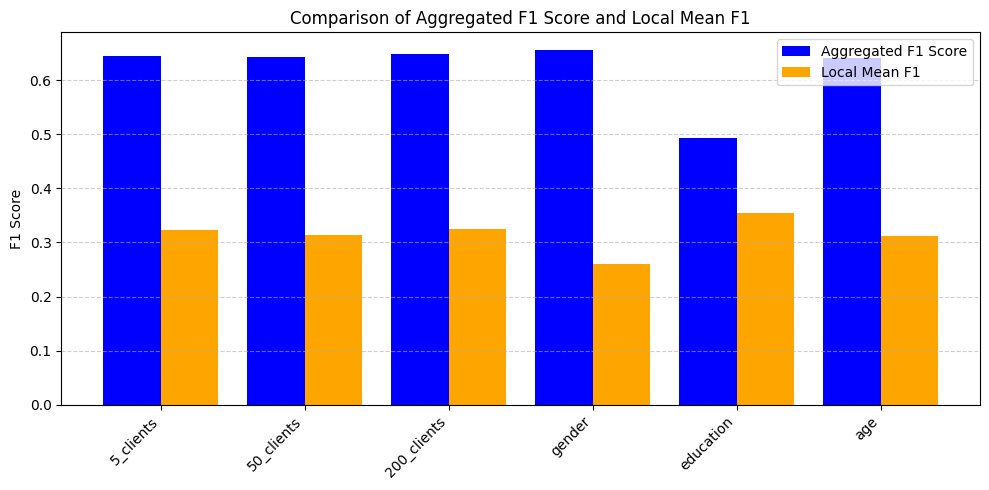

In [76]:
categories = []
f1_scores = []
local_mean_f1s = []

for category, metrics in averages.items():
    if "f1_score" in metrics and "local_mean_f1" in metrics:
        categories.append(category)
        f1_scores.append(metrics["f1_score"])
        local_mean_f1s.append(metrics["local_mean_f1"])

categories = np.array(categories)
f1_scores = np.array(f1_scores)
local_mean_f1s = np.array(local_mean_f1s)

x = np.arange(len(categories))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, f1_scores, width=0.4, label="Aggregated F1 Score", color="blue")
plt.bar(x + 0.2, local_mean_f1s, width=0.4, label="Local Mean F1", color="orange")

plt.xticks(x, categories, rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("Comparison of Aggregated F1 Score and Local Mean F1")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


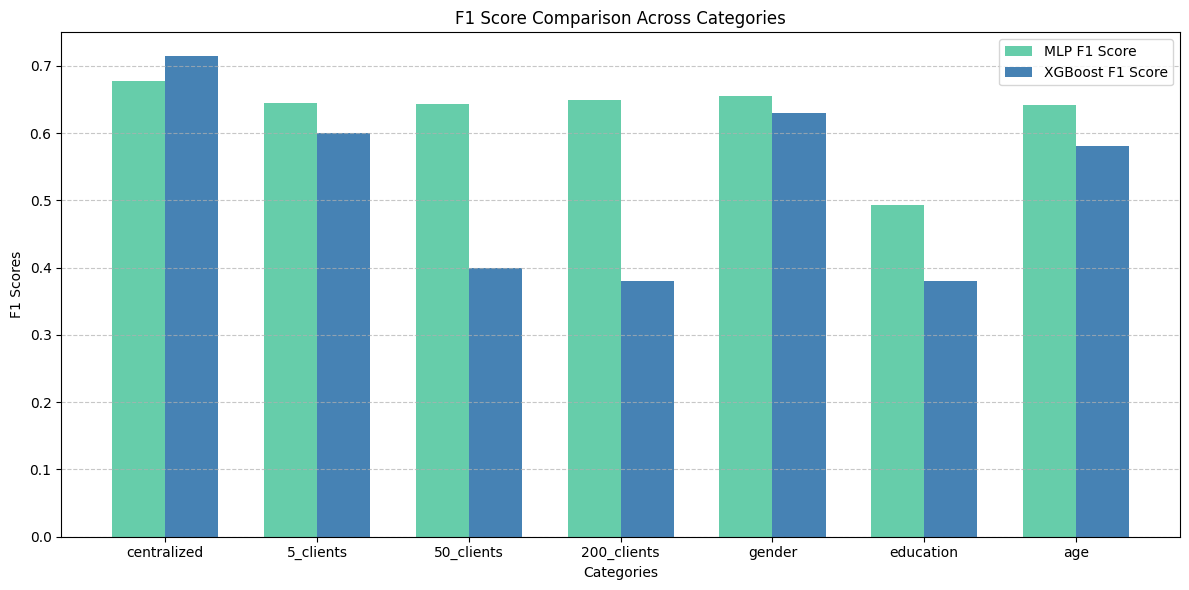

In [19]:
f1_scores = {category: averages[category]['f1_score'] for category in averages}
xgboost_f1_scores = [0.7140, 0.6, 0.4, 0.38, 0.63, 0.38, 0.58]

categories = list(f1_scores.keys())

x = np.arange(len(categories)) 
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

avg_color = 'mediumaquamarine'
xgb_color = 'steelblue'

ax.bar(x - width/2, list(f1_scores.values()), width, label='MLP F1 Score', color=avg_color)
ax.bar(x + width/2, xgboost_f1_scores, width, label='XGBoost F1 Score', color=xgb_color)

ax.set_xlabel("Categories")
ax.set_ylabel("F1 Scores")
ax.set_title("F1 Score Comparison Across Categories")

ax.set_xticks(x)
ax.set_xticklabels(categories)

ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.legend()
plt.tight_layout()
plt.show()